In [268]:
import gym
from gym import spaces
import numpy as np
import os
import pandas as pd
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.evaluation import evaluate_policy
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from stable_baselines3.common.env_checker import check_env

SLIDE_WINDOW_SIZE = 25  # size of the slide window 1 if default statefunction is chosen

class CustomEnv(gym.Env):
  """Custom Environment that follows gym interface"""
  metadata = {'render.modes': ['human']}

  def __init__(self, scaler = MinMaxScaler(), file="test.csv" ,dir="./series/", verbose=True):
    super(CustomEnv, self).__init__()
    self.filename = file
    self.file = os.path.join(dir + self.filename)
    self.cursor = -1
    self.cursor_init = 0
    self.isdone = False
    self.statefunction = self.__get_state_q
    self.rewardfunction = self.__get_reward_q
    self.scaler = scaler

    self.timeseries_labeled = pd.read_csv(os.path.join(dir + file), usecols=[1, 2], header=0, sep=",",
                                          names=['value', 'anomaly'],
                                          encoding="utf-8")

    # Define action and observation space
    # They must be gym.spaces objects
    # Example when using discrete actions:
    self.action_space = spaces.Discrete(2)
    # Example for using image as input:
    self.observation_space = spaces.Box(low=0.0, high=1.0,
                                        shape=(SLIDE_WINDOW_SIZE,), dtype=np.float32)
    if verbose:
        print(self.__str__())


  # def step(self, action):
  #   reward = self.__get_reward_q(self.timeseries_labeled, self.cursor, action)
  #   state = self.__get_state_q(self.timeseries_labeled, self.cursor)
  #   self.cursor += 1
  #   state_ = self.__get_state_q(self.timeseries_labeled, self.cursor)
  #   done = self.cursor >= len(self.timeseries_labeled) - 1
  #   return state, reward, done, {}
  def step(self, action):
    reward = self.__get_reward_q(self.timeseries_labeled, self.cursor, action)
    state = self.__get_state_q(self.timeseries_labeled, self.cursor)
    self.cursor += 1
    if self.cursor >= self.timeseries_labeled['value'].size:
        done = True
        next_state = []
    else:
        done = False
        next_state = self.statefunction(self.timeseries_labeled, self.cursor)
    return state, reward, done, {}

  def reset(self):
    self.cursor = self.cursor_init
    self.isdone = False
    self.normalize_timeseries()
    init_state = self.statefunction(self.timeseries_labeled, self.cursor)
    return init_state

  def render(self, mode='human'):
    pass

  def close (self):
    pass

  def __get_state_q(self, timeseries, cursor):
    """
    :param timeseries_cursor: the position where in the TimeSeries we are currently
    :return: The Value of the current position, states with the same value are treated the same way
    """
    return np.asarray([np.float64(timeseries['value'][cursor])])

  def __get_reward_q(self, timeseries, cursor, action):
    """
    :param timeseries_cursor: the position where in the TimeSeries we are currently
    :param action: the chosen action (the label we put on the state, Anomaly or Normal)
    :return: Rewards shaped inside the Config File
    """
    if action == timeseries['anomaly'][cursor]:
        return 1
    else:
        return -1

  def __str__(self):
    """
    :return: String Representation of the TimeSeriesEnvironment Class, mainly for debug information
    """
    return "TimeSeries from: {}\n Header(labeled):\n {} \nRows:\n " \
           "{}\nMeanValue:\n {}\nMaxValue:\n {}\nMinValue:\n {}".format(
        self.filename,
        self.timeseries_labeled.head(
            3),
        self.timeseries_labeled.shape[0],
        round(self.timeseries_labeled["value"].mean(), 2),
        round(self.timeseries_labeled["value"].max(), 2),
        round(self.timeseries_labeled["value"].min(), 2))

  def normalize_timeseries(self):
    self.timeseries_labeled["value"] = self.scaler.fit_transform(self.timeseries_labeled[["value"]])

Test if environment is legit

In [152]:
env = CustomEnv()
# It will check your custom environment and output additional warnings if needed
check_env(env)


TimeSeries from: test.csv
 Header(labeled):
    value  anomaly
0      0        0
1      0        0
2      4        0 
Rows:
 1424
MeanValue:
 40.39
MaxValue:
 452
MinValue:
 0


/home/nj/anaconda3/envs/pythonProject/lib/python3.8/site-packages/stable_baselines3/common/env_checker.py:219: UserWarning: Your observation has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector
  warnings.warn(


AssertionError: The observation returned by the `reset()` method does not match the given observation space

In [ ]:
# Define and Train the agent
model = PPO('MlpPolicy', env, n_steps=2048, batch_size=24, n_epochs=10, gamma=0.9,)
#model = DQN("MlpPolicy", env)
model.learn(total_timesteps=10000)

In [262]:
# Create a custom evaluator

def evaluate(model, num_episodes=10):
    """
    Evaluate a RL agent
    :param model: (BaseRLModel object) the RL Agent
    :param num_episodes: (int) number of episodes to evaluate it
    :return: (float) Mean reward for the last num_episodes
    """
    # This function will only work for a single Environment
    env = model.get_env()
    # Using an Array to track all rewards over all episodes
    all_episode_rewards = []
    all_episode_actions = []
    for i in range(num_episodes):
        # testing for each episode on complete run until the environment is done
        episode_rewards = []
        episode_actions = []
        done = False
        # get the first observation out of the environment
        obs = env.reset()
        while not done:
            # _states are only useful when using LSTM policies
            action, _states = model.predict(obs)
            # here, action, rewards and dones are arrays
            # because we are using vectorized env
            obs, reward, done, info = env.step(action)
            episode_actions.append(int(action))
            episode_rewards.append(reward)

        all_episode_actions.append(episode_actions)
        all_episode_rewards.append(sum(episode_rewards))
        best_episode_idx = np.argmax(all_episode_rewards)
        best_episode_actions = all_episode_actions[best_episode_idx]

    print("Maximum Reward: ", np.max(all_episode_rewards),
          "\nAverage Reward: ", np.mean(all_episode_rewards), "\nEpisodes: ", num_episodes)
    plot_result(model.get_env(), best_episode_actions)

def plot_result(env, actions):
    series = pd.DataFrame(env.get_attr("timeseries_labeled")[0])
    plt.figure(figsize=(15, 7))
    plt.plot(series.index , actions, label="Actions", linestyle="solid")
    plt.plot(series.index , series["anomaly"] , label="True Label", linestyle="dotted")
    plt.plot(series.index , series["value"] , label="Series", linestyle="dashed")
    plt.legend()
    plt.ylabel('Reward Sum')
    plt.show()

In [ ]:
evaluate(model)

As we can see our agent has too few information in its state to approximate the correct value function
therefore we are trying to increase the state information by introducing a sliding window state

In [269]:
def SlideWindowStateFuc(timeseries, timeseries_cursor, timeseries_states=None, action=None):
    if timeseries_cursor >= SLIDE_WINDOW_SIZE:
        return [timeseries['value'][i + 1]
                for i in range(timeseries_cursor - SLIDE_WINDOW_SIZE, timeseries_cursor)]
    else:
        return np.zeros(SLIDE_WINDOW_SIZE)


def SlideWindowRewardFuc(timeseries, timeseries_cursor, action):
    if timeseries_cursor >= SLIDE_WINDOW_SIZE:
        sum_anomaly = np.sum(timeseries['anomaly']
                             [timeseries_cursor - SLIDE_WINDOW_SIZE + 1:timeseries_cursor + 1])
        if sum_anomaly == 0:
            if action == 0:
                return 1  # 0.1      # true negative
            else:
                return -1  # 0.5     # false positive, error alarm

        if sum_anomaly > 0:
            if action == 0:
                return -5  # false negative, miss alarm
            else:
                return 5  # 10      # true positive
    else:
        return 0

In [ ]:
# now we try again by setting our new functions

In [272]:
env = CustomEnv()
env.__setattr__("statefunction", SlideWindowStateFuc)
env.__setattr__("rewardfunction", SlideWindowRewardFuc)
#env.__setattr__("cursor_init", 25)
# check the env
# It will check your custom environment and output additional warnings if needed
#model = PPO('MlpPolicy', env, learning_rate=0.01, n_steps=2048, batch_size=48, n_epochs=2,
#            gamma=0.9, gae_lambda=0.9,use_sde=False,
#            clip_range=0.2, clip_range_vf=None, ent_coef=0.0, vf_coef=0.5, max_grad_norm=0.5,)
model = DQN("MlpPolicy", env, learning_rate=0.001, buffer_size=50000, learning_starts=5000,
            batch_size=SLIDE_WINDOW_SIZE, tau=1.0, gamma=0.9, train_freq=4, gradient_steps=1,
            n_episodes_rollout=- 1, optimize_memory_usage=False, #
            target_update_interval=100, exploration_fraction=0.1, exploration_initial_eps=1.0,
            exploration_final_eps=0.0, max_grad_norm=10, tensorboard_log=None, create_eval_env=False,
            policy_kwargs=None, verbose=0, seed=None, device='auto', _init_setup_model=True)
model.learn(total_timesteps=1000000)

TimeSeries from: test.csv
 Header(labeled):
    value  anomaly
0      0        0
1      0        0
2      4        0 
Rows:
 1424
MeanValue:
 40.39
MaxValue:
 452
MinValue:
 0


Maximum Reward:  1338.0 
Average Reward:  1338.0 
Episodes:  10


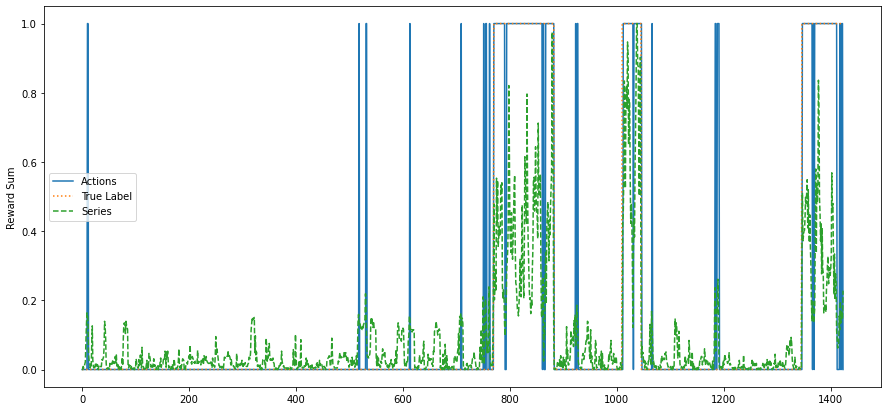

In [273]:
env.__setattr__("cursor_init", 0)
evaluate(model, num_episodes=10)
